# SAYCam dataset processing



Chris Iyer

updated 11/19/24

In [1]:
import os, glob, cv2
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from utils import pickle_save_dict, pickle_load_dict, compute_stats 
from video_processing import load_model, read_embed_video, plot_frames
from autocorrelation import get_consec_dists, run_plot_acf, get_familiarity_timeseries
# these ^^^ are the important fxns! 

In [2]:
N_JOBS = 8
MODEL_NAME = 'vit' # 'vit' or 'resnet' # respectively, these will make 768-D or 2048-D embeddings
DOWNSAMPLED_FR = 3
OUTPUT_DIR = 'outputs'

## View example frames

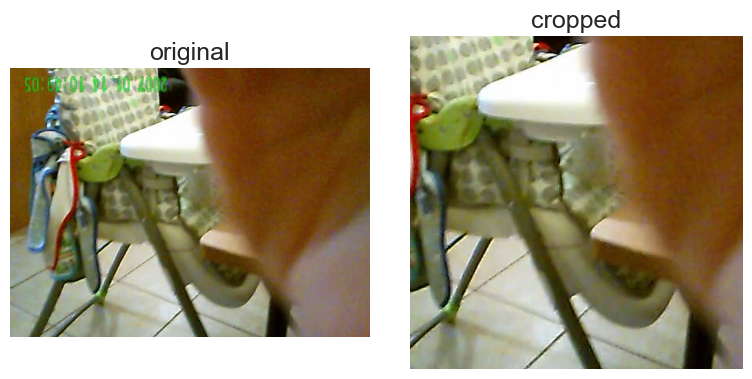

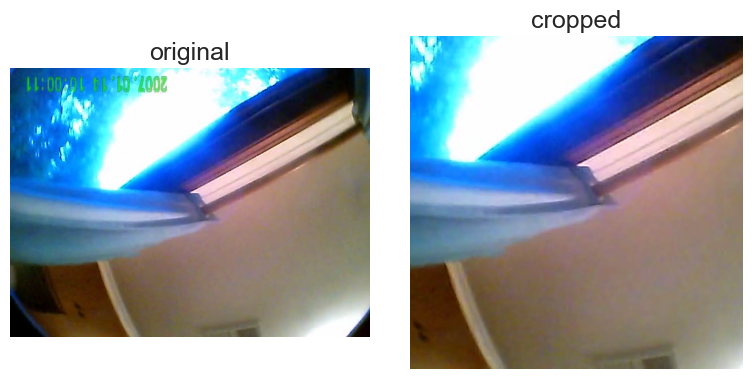

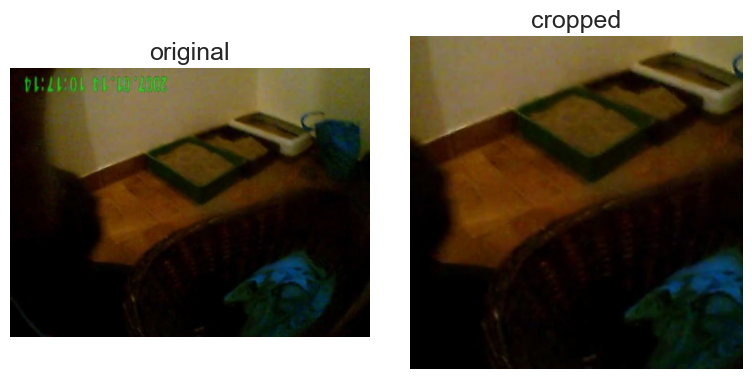

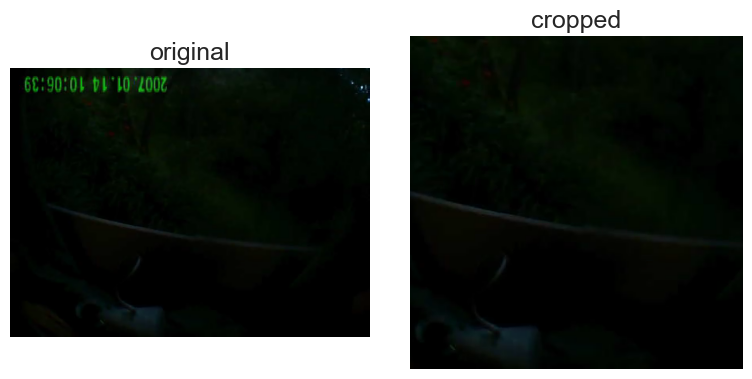

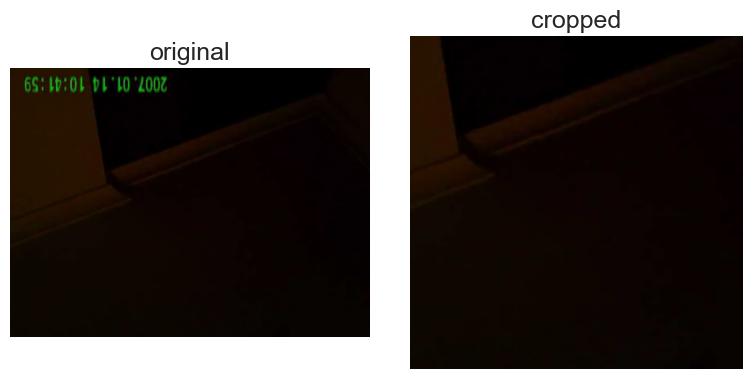

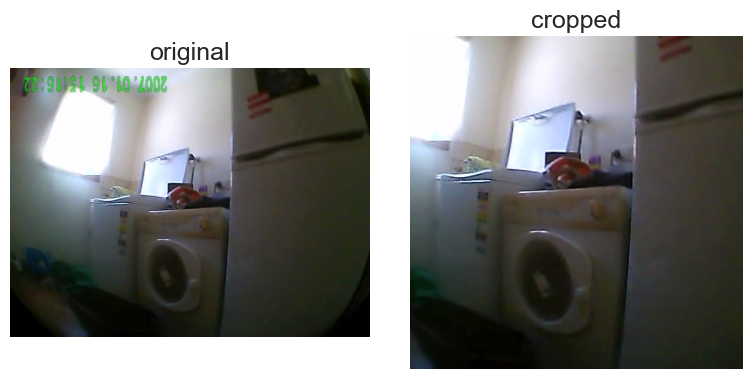

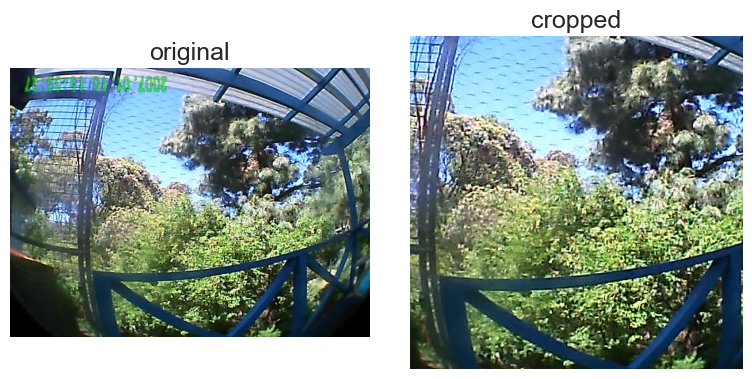

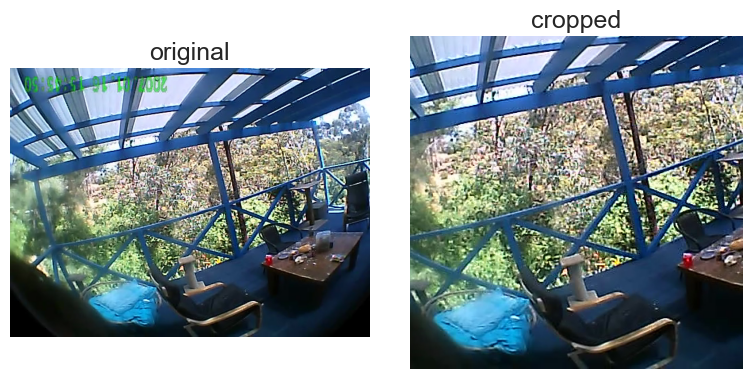

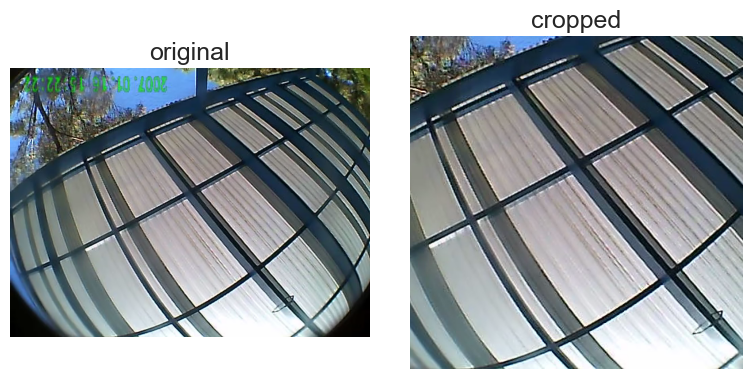

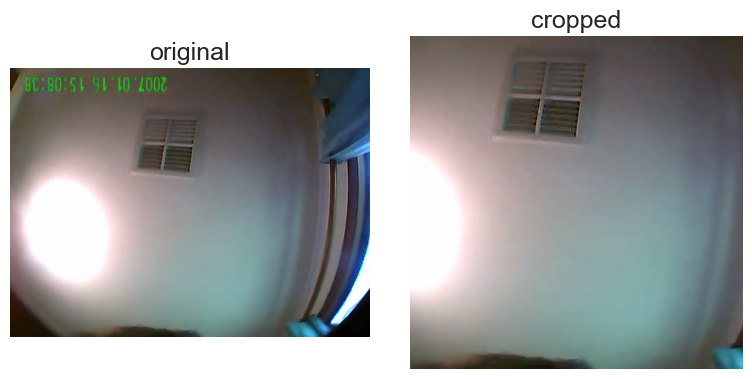

In [3]:
# See example frames (second frame of each video) and the different preprocessing steps
video_paths = glob.glob('33*/*.mp4')

for video in video_paths:
    # second frame of video
    frame1 = read_embed_video(video, n_frames=2, preprocess=False, model_name=None, save_folder=None, n_jobs=1)[1] # gets the second frame
    frame2 = read_embed_video(video, n_frames=2, preprocess=True, model_name=None, save_folder=None, n_jobs=1)[1]
    plot_frames([cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)[::-1,::-1,:] , frame2], ['original', 'cropped'])

# video = video_paths[-1]
# frame = load_video(video, n_frames=1, downsampled_frame_rate=1)[0] # downsample to 3 Hz
# plot_frame(frame, title=video)

## Model embedding 

Google vision transformer https://huggingface.co/docs/transformers/en/model_doc/vit

Resnet: https://huggingface.co/docs/transformers/en/model_doc/resnet

In [ ]:
# compute and save model embeddings of all frames in the test videos

save_folder = os.path.join(OUTPUT_DIR, 'video_embeddings')
video_paths = sorted(glob.glob('33*/*.mp4'))

for i,video in enumerate(video_paths):
    print(f'Beginning video {i+1} out of {len(video_paths)}')
    embeddings = read_embed_video(video, n_frames=None, downsampled_frame_rate=DOWNSAMPLED_FR, 
                                  preprocess=True, model_name=MODEL_NAME, save_folder=save_folder, n_jobs=N_JOBS)
    
    if save_folder:
        print(f'Saving results to {save_folder}, shape: {embeddings.shape}')

# code for saving an entire array with pkl instead:
# pickle_save_dict(embedding_list, outpath)

Beginning video 1 out of 10
Saving results to video_embeddings, shape: (1066, 768)
Beginning video 2 out of 10
Saving results to video_embeddings, shape: (1896, 768)
Beginning video 3 out of 10
Saving results to video_embeddings, shape: (3050, 768)
Beginning video 4 out of 10
Saving results to video_embeddings, shape: (1257, 768)
Beginning video 5 out of 10
Saving results to video_embeddings, shape: (1052, 768)
Beginning video 6 out of 10
Saving results to video_embeddings, shape: (1382, 768)
Beginning video 7 out of 10
Saving results to video_embeddings, shape: (1043, 768)
Beginning video 8 out of 10
Saving results to video_embeddings, shape: (3065, 768)
Beginning video 9 out of 10
Saving results to video_embeddings, shape: (1123, 768)
Beginning video 10 out of 10
Saving results to video_embeddings, shape: (1923, 768)


In [5]:
# how much larger are the videos compared to embeddings?
video_paths = sorted(glob.glob('33*/*.mp4'))
for model in ['vit', 'resnet']:
    e_to_v_ratios = []
    embedding_paths = sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/*/*{model}*'))

    for e,v in zip(embedding_paths, video_paths):
        e_to_v_ratios.append(os.path.getsize(e)/os.path.getsize(v))

    print(f'{model} average embedding-to-video ratio: {np.round(np.mean(e_to_v_ratios), 2)}')

vit average embedding-to-video ratio: 0.03
resnet average embedding-to-video ratio: 0.08


## Raw autocorrelation

In [6]:
# Load embeddings if not already loaded
embeddings_paths = sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/*/*{MODEL_NAME}*.npy'))
all_embeddings = [np.load(e) for e in embeddings_paths]

first, we want to look for a power law decay in the autocorrelation function over time (not looking at gap or threshold)

Computing autocorrelation of raw embeddings...


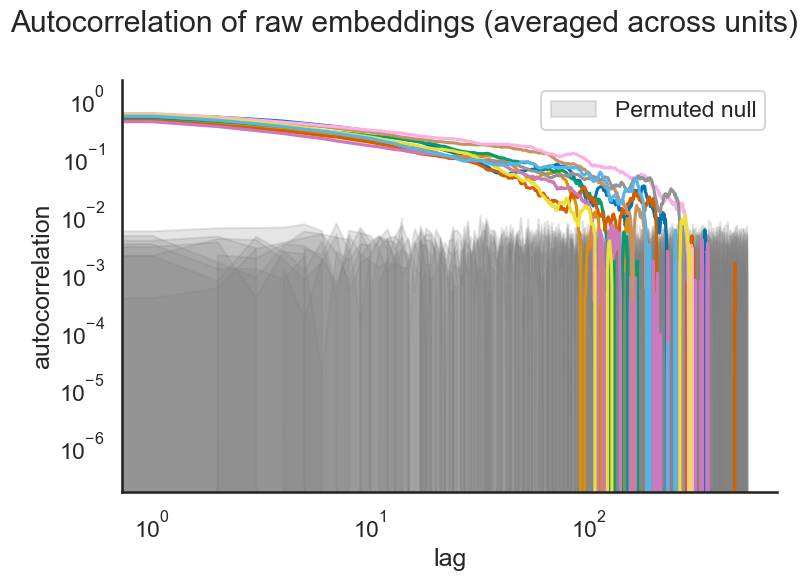

In [7]:
_ = run_plot_acf(all_embeddings, permute=True, n_jobs=N_JOBS, plot=True, save_folder=OUTPUT_DIR)
# n = 50000, nlags = 20000 

## Calculate pairwise distances 

In [8]:
# Load embeddings if not already loaded
embeddings_paths = sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/*/*{MODEL_NAME}*.npy'))
all_embeddings = [np.load(e) for e in embeddings_paths]

100%|██████████| 10/10 [00:00<00:00, 43.96it/s]


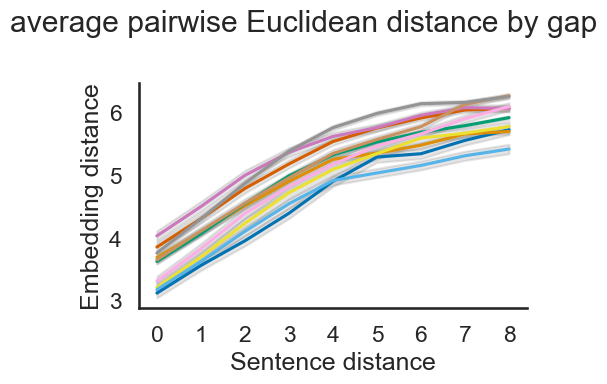

In [9]:
consec_dist = get_consec_dists(all_embeddings, save_folder=OUTPUT_DIR, plot=True)

## Familiarity/novelty autocorrelation

now, we will choose a threshold to define familiar vs. novel events (frame embeddings). We will choose a radius (based on the results above of pairwise distances) and take the union of circles around the datapoints to get the "familiarity ball". We will do this ignoring the last <gap> events (WM). Then, events will be marked as either familiar or novel based on their presence in that region.

Finally, we'll compute autocorrelation of that binary vector.

In [10]:
# Load embeddings if not already loaded
embeddings_paths = sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/*/*{MODEL_NAME}*.npy'))
all_embeddings = [np.load(e) for e in embeddings_paths]

# load consec_dists if not already loaded
consec_dist = pickle_load_dict(OUTPUT_DIR + '/consec_dist/consec_dist.pkl')

Computing autocorrelation of familiarity timeseries...


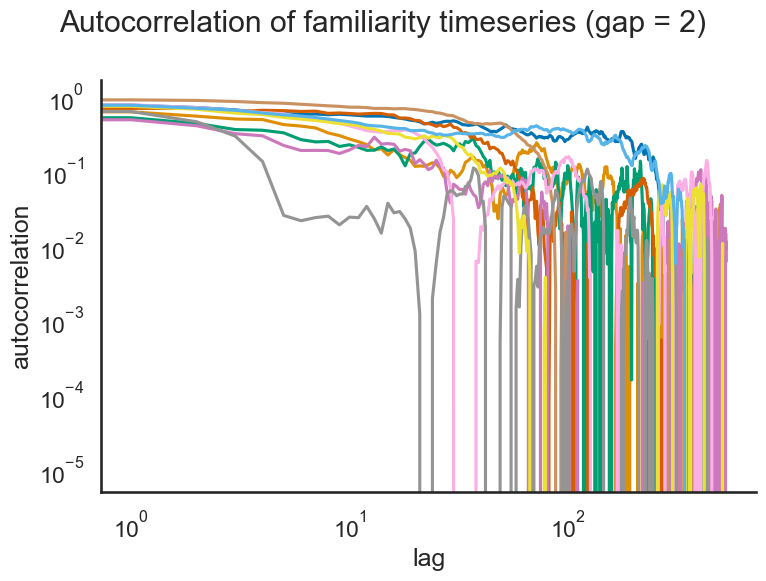

Computing autocorrelation of familiarity timeseries...


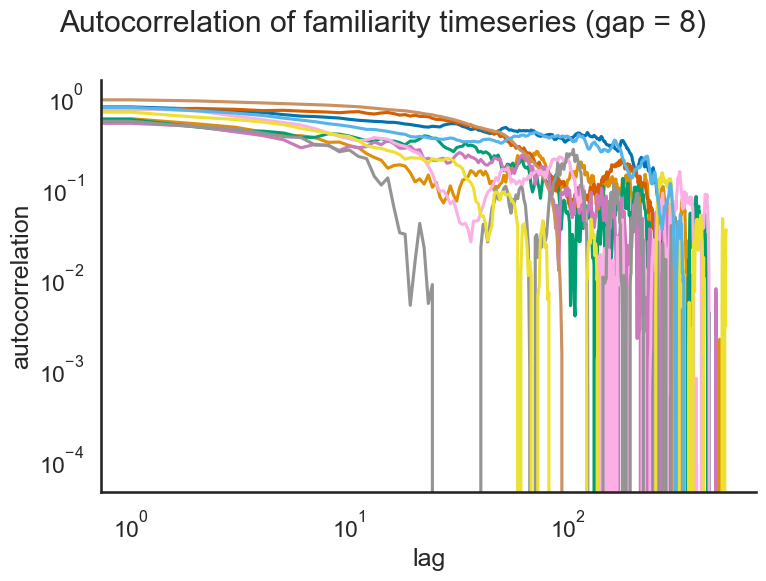

Computing autocorrelation of familiarity timeseries...


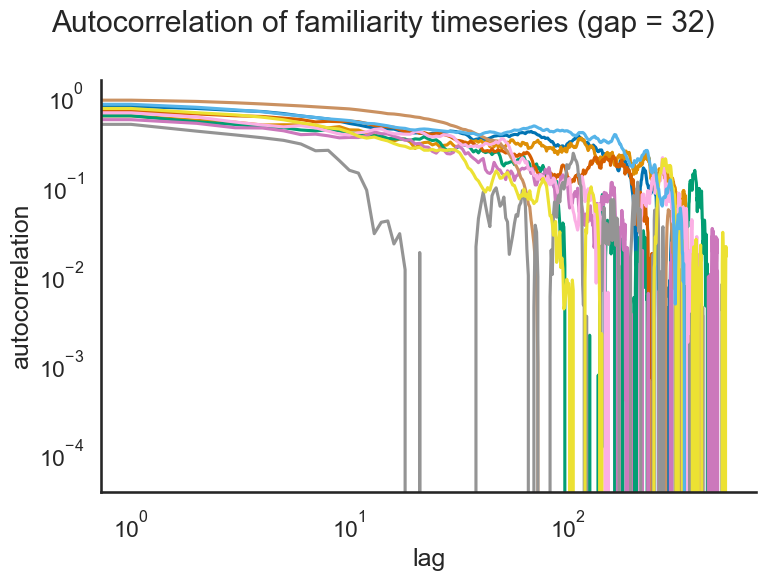

Computing autocorrelation of familiarity timeseries...


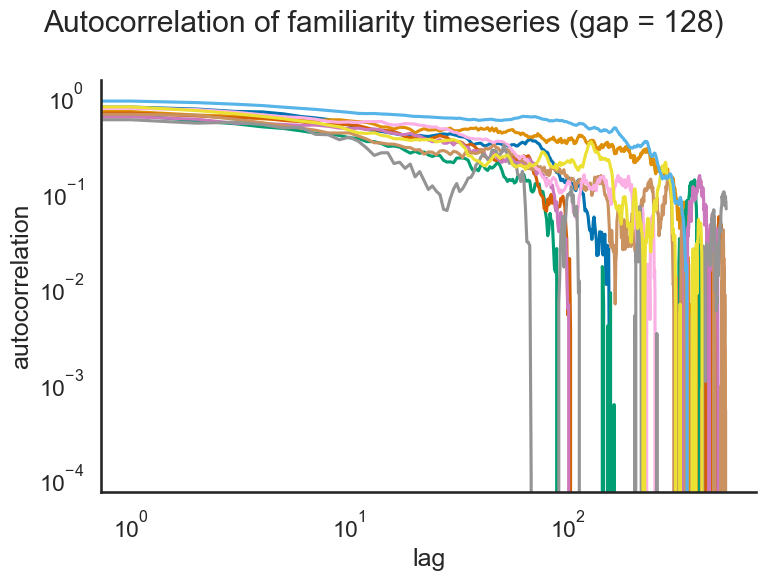

In [11]:
for gap in [2, 8, 32, 128]:
    familiarity_ts = get_familiarity_timeseries(all_embeddings, consec_dist, gap, n_jobs=N_JOBS)
    _ = run_plot_acf(familiarity_ts,  n=None, nlags=None, permute=False, n_jobs=N_JOBS, plot=True, 
                        save_folder=OUTPUT_DIR, title_add = f' (gap = {gap})')

In [ ]:
# def apply_pca(X, n_components=None):
#     pca = PCA(n_components=n_components)
#     X_pca = pca.fit_transform(X)
#     explained_variance_ratio = pca.explained_variance_ratio_
#     return X_pca, explained_variance_ratio, pca

# n_components = dim  # Number of principal components to keep
# X_pca, explained_variance_ratio, pca_model = apply_pca(embeddings, n_components)

# f, ax = plt.subplots(1,1, figsize=(5,4))
# ax.plot(np.cumsum(explained_variance_ratio))
# ax.set_xlabel('# PCs')
# ax.set_ylabel('cum. var. explaiend')
# sns.despine()
# f.tight_layout()
# f, ax = plt.subplots(1,1, figsize=(5,4))
# # ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
# ax.scatter(X_pca[:, 0], X_pca[:, 1], c=np.arange(n), cmap='viridis')
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# sns.despine()
# f.tight_layout()